# Recurrent 2D Convolutional Neural Network for ECG Binary Classification

This notebook presents a hybrid model that builds upon components explored in previous experiments within the project. The proposed architecture combines Gated Recurrent Units (GRUs), which have shown strong performance on sequential ECG data, with a two-dimensional convolutional approach applied to the spectrogram of the signal.

The goal of this model is to leverage the strengths of both techniques: the ability of GRUs to capture temporal dependencies in the data, and the effectiveness of 2D convolutional layers in extracting spatial patterns from spectrogram representations. The convolutional component is based on the model introduced in the notebook "Simple 2D Convolutional Neural Network for ECG Binary Classification", where the spectrogram proved to be a valuable feature representation for classification tasks.

## Dataset and dependencies loading

In [1]:
!git clone https://github.com/dokunoale/chagas.git
!pip install -q -r chagas/requirements.txt


# Download the dataset
import gdown
url = "https://drive.google.com/file/d/1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC/view?usp=drive_link"
gdown.download(url, "dataset.zip", quiet=False, fuzzy=True)
!unzip -q /content/dataset.zip -d chagas/data/

Cloning into 'chagas'...
remote: Enumerating objects: 669, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 669 (delta 55), reused 46 (delta 46), pack-reused 565 (from 2)
Receiving objects: 100% (669/669), 9.96 MiB | 6.57 MiB/s, done.
Resolving deltas: 100% (329/329), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 27.3 MB/s eta 0:00:00


Downloading...
From (original): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC
From (redirected): https://drive.google.com/uc?id=1vK_gMI36xjdtiJjMBV7dKHurIExQs4hC&confirm=t&uuid=1ab8afad-b455-4555-ae08-a4e081153063
To: /content/dataset.zip
100%|██████████| 623M/623M [00:02<00:00, 210MB/s]


In [2]:
import sys
sys.path.append("/content/chagas/src")


import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

This code sets up the validation and test datasets for a Chagas disease classification task using ECG recordings. It begins by defining a custom noise reduction filter (`FiltfiltNoiseReducer`) with parameters tailored for ECG signals sampled at 400 Hz. Then, using a data loader (`WfdbLoader`), it applies the filter and loads ECG recordings labeled for the presence or absence of Chagas disease from specified directories. The data is shuffled during loading to ensure randomized batches. Finally, the metadata for the test set is retrieved for further analysis or tracking.

In [3]:
from preprocessing.tf_dataset_loader import WfdbLoader
from preprocessing.filters import FiltfiltNoiseReducer


data_path = "/content/chagas/data/big_splitted_dataset/"

# Noise reduction filter
filter = FiltfiltNoiseReducer(fs=400, iir_freq=60.0, butterworth_cutoff=5., lowpass_cutoff=60., verbose=True)

# training set loading and preprocessing
train = WfdbLoader(label = 'Chagas label')
train.add_filter(filter)
train.add_dataset(data_path + "train/positives")
train.add_dataset(data_path + "train/negatives")
X_train, y_train = train.load(shuffle=True, verbose=True)

# validation set loading and preprocessing
validation = WfdbLoader(label = 'Chagas label')
validation.add_filter(filter)
validation.add_dataset(data_path + "val/positives")
validation.add_dataset(data_path + "val/negatives")
X_val, y_val = validation.load(shuffle=True, verbose=True)

# test set loading and preprocessing
test = WfdbLoader(label = 'Chagas label')
test.add_filter(filter)
test.add_dataset(data_path + "test/positives")
test.add_dataset(data_path + "test/negatives")
X_test, y_test = test.load(shuffle=True, verbose=True)

# Array of dictionaries with more info for model analysis
y_test_info = test.get_metadata()

Filtering records - filtfilt: 100%|██████████| 2245/2245 [00:14<00:00, 153.29record/s]


# Training

In this model, we integrate concepts previously explored in earlier experiments, including simple CNNs, GRUs, and the combination of 1D CNNs with GRUs. The convolutional component, which has been discussed in depth in prior notebooks, serves to extract spatial features from the input ECG signals.

The 2D convolutional block, applied after converting the raw ECG signals into a logarithmic spectrogram, allows the model to capture important frequency and temporal patterns in the spectrogram domain. This process has proven effective in identifying relevant features for ECG classification, leveraging the ability of convolutional layers to learn localized patterns at different frequency scales.

A custom temporal pooling layer, designed to preserve the temporal structure between the convolutional and GRU layers, ensures that the extracted spatial features maintain their temporal coherence. This approach optimizes the transition from spatial feature extraction to sequence modeling, helping to retain the crucial time-dependent information.

Finally, the GRU layers, which were previously used in simpler forms of recurrent architectures, are employed here to model the temporal dependencies in the ECG data. This combination of convolutional and recurrent layers is intended to effectively capture both the spatial and temporal features of ECG signals for improved classification.


In [4]:
from models.layers import LightLogSpectrogram, TemporalMeanPooling

def build_cnn_model(input_shape=(2800, 12)):
    inputs = tf.keras.Input(shape=input_shape)  # 12-lead ECG time series

    # Logarithmic spectrogram
    x = LightLogSpectrogram()(inputs)  # shape: [batch, time, freq, 12]

    # Simple Conv2D block
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_32")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_64')(x)
    x = TemporalMeanPooling(name="temporal_pooling")(x)

    # GRU con 64 canali in input
    x = tf.keras.layers.GRU(32, return_sequences=True, name='gru_32_sequence')(x)  # output: (None, 32)
    x = tf.keras.layers.GRU(32, return_sequences=False, name='gru_32')(x)  # [batch, 32]

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Binary output

    return tf.keras.Model(inputs, outputs, name="RCNN")

# Compilazione del modello
model = build_cnn_model(input_shape=(2800, 12))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

Model: "RCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2800, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ light_log_spectrogram           │ (None, 88, 64, 12)     │             0 │
│ (LightLogSpectrogram)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_32 (Conv2D)                │ (None, 88, 64, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 44, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_64 (Conv2D)                │ (None, 44, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_pooling                │ (None, 44, 64)         │             0 │
│ (TemporalMeanPooling)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32_sequence (GRU)           │ (None, 44, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,761 (147.50 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Callback: early stopping e salvataggio del modello migliore
early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True)

callbacks = [early_stop, checkpoint]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=30,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.4952 - auc: 0.4943 - loss: 0.7023 - val_accuracy: 0.5009 - val_auc: 0.5324 - val_loss: 0.6943
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5137 - auc: 0.5206 - loss: 0.6940 - val_accuracy: 0.5053 - val_auc: 0.5550 - val_loss: 0.6970
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5271 - auc: 0.5413 - loss: 0.6911 - val_accuracy: 0.5000 - val_auc: 0.6761 - val_loss: 0.7185
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6063 - auc: 0.6490 - loss: 0.6602 - val_accuracy: 0.6756 - val_auc: 0.7415 - val_loss: 0.6012
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6697 - auc: 0.7288 - loss: 0.6083 - val_accuracy: 0.6765 - val_auc: 0.7501 - val_loss: 0.5975
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6850 - auc: 0.7487 - loss: 0.5937 - val_accuracy: 0.6898 - val_auc: 0.7610 - val_loss: 0.5927
Epoch 7/50
262/262 ━━━━━━━━━━━━

## Model Analysis

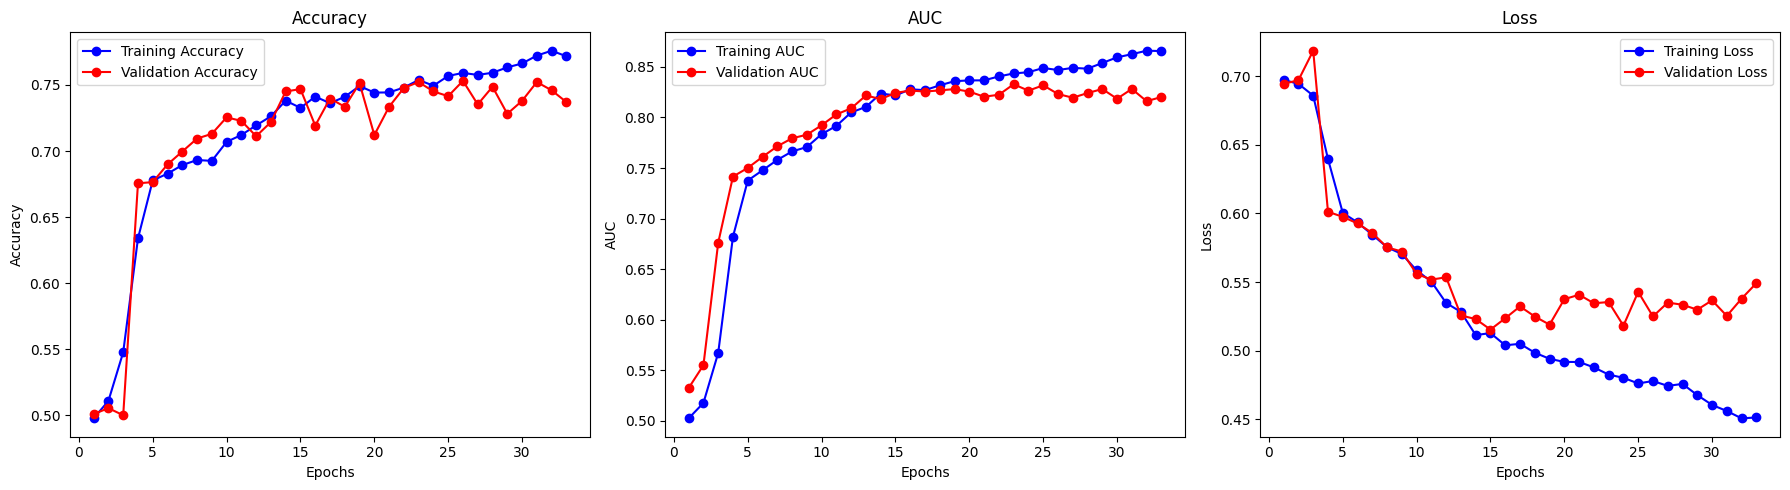

In [6]:
from models.analysis import plot_training_metrics

# accuracy, AUC and loss plot
plot_training_metrics(history)

In [7]:
from models.utils import find_optimal_threshold, compute_predictions
from sklearn.metrics import classification_report, accuracy_score
from models.layers import TemporalMeanPooling, LightLogSpectrogram


# Load the trained Keras model from file, specifying any custom layers used
model = tf.keras.models.load_model(
    "best_model.keras",
    safe_mode=False,
    custom_objects={'TemporalMeanPooling': TemporalMeanPooling,
                    'LightLogSpectrogram': LightLogSpectrogram}
)

# Generate predicted probabilities on the validation set
y_pred_probs = model.predict(X_val)

# Find the optimal classification threshold based on the validation set
threshold = find_optimal_threshold(y_val, y_pred_probs)

# Compute final predictions, predicted classes, and correctness flags on the test set
y_pred, y_pred_classes, correct = compute_predictions(model, X_test, y_test, threshold)

# Print a detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred_classes))

# Compute and store the overall accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)
print(accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
Optimal threshold: 0.590
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1126
           1       0.74      0.77      0.76      1119

    accuracy                           0.75      2245
   macro avg       0.75      0.75      0.75      2245
weighted avg       0.75      0.75      0.75      2245

0.7496659242761693


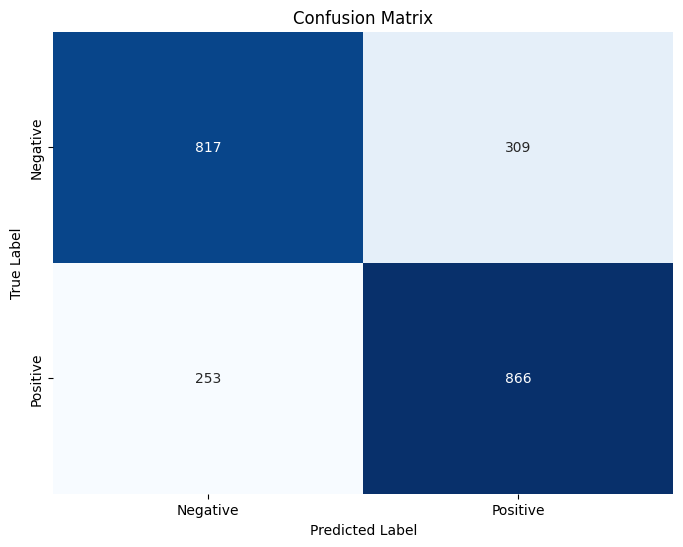

In [8]:
from models.analysis import plot_confusion_matrix


# Confusion matrix
plot_confusion_matrix(y_test, y_pred_classes)

The next cell provides a summary of the distribution of the model's output scores.

- **Distribution of predictions**: Displays the distribution of predicted probabilities, highlighting correct (blue) and incorrect (red) classifications. A vertical dashed line indicates the 0.5 threshold, which may vary depending on the decision criterion.

- **Source distribution by model output**: Shows how the model's output scores (x-axis) are distributed across subgroups defined by data origin and label. This allows us to assess how different dataset segments are classified and to detect potential imbalances. Groups include:

    - Chagas-negative cases from CODE-15% (light teal),

    - Chagas-positive cases from CODE-15% (teal),

    - Chagas-positive cases from SaMi-Trop (yellow).

- **Age distribution for correct predictions**: Depicts the distribution of model outputs for correctly classified samples, stratified by age group. This provides insight into how prediction confidence varies across age.

- **Age distribution for incorrect predictions**: Analogous to the previous chart but focused on misclassifications. It helps identify age groups with higher error rates or ambiguous outputs.

- **Prediction success rate by age**: Summarizes the model's classification accuracy by age group, expressed as a percentage of correct predictions. Sample counts per group are reported above each bar for context.

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


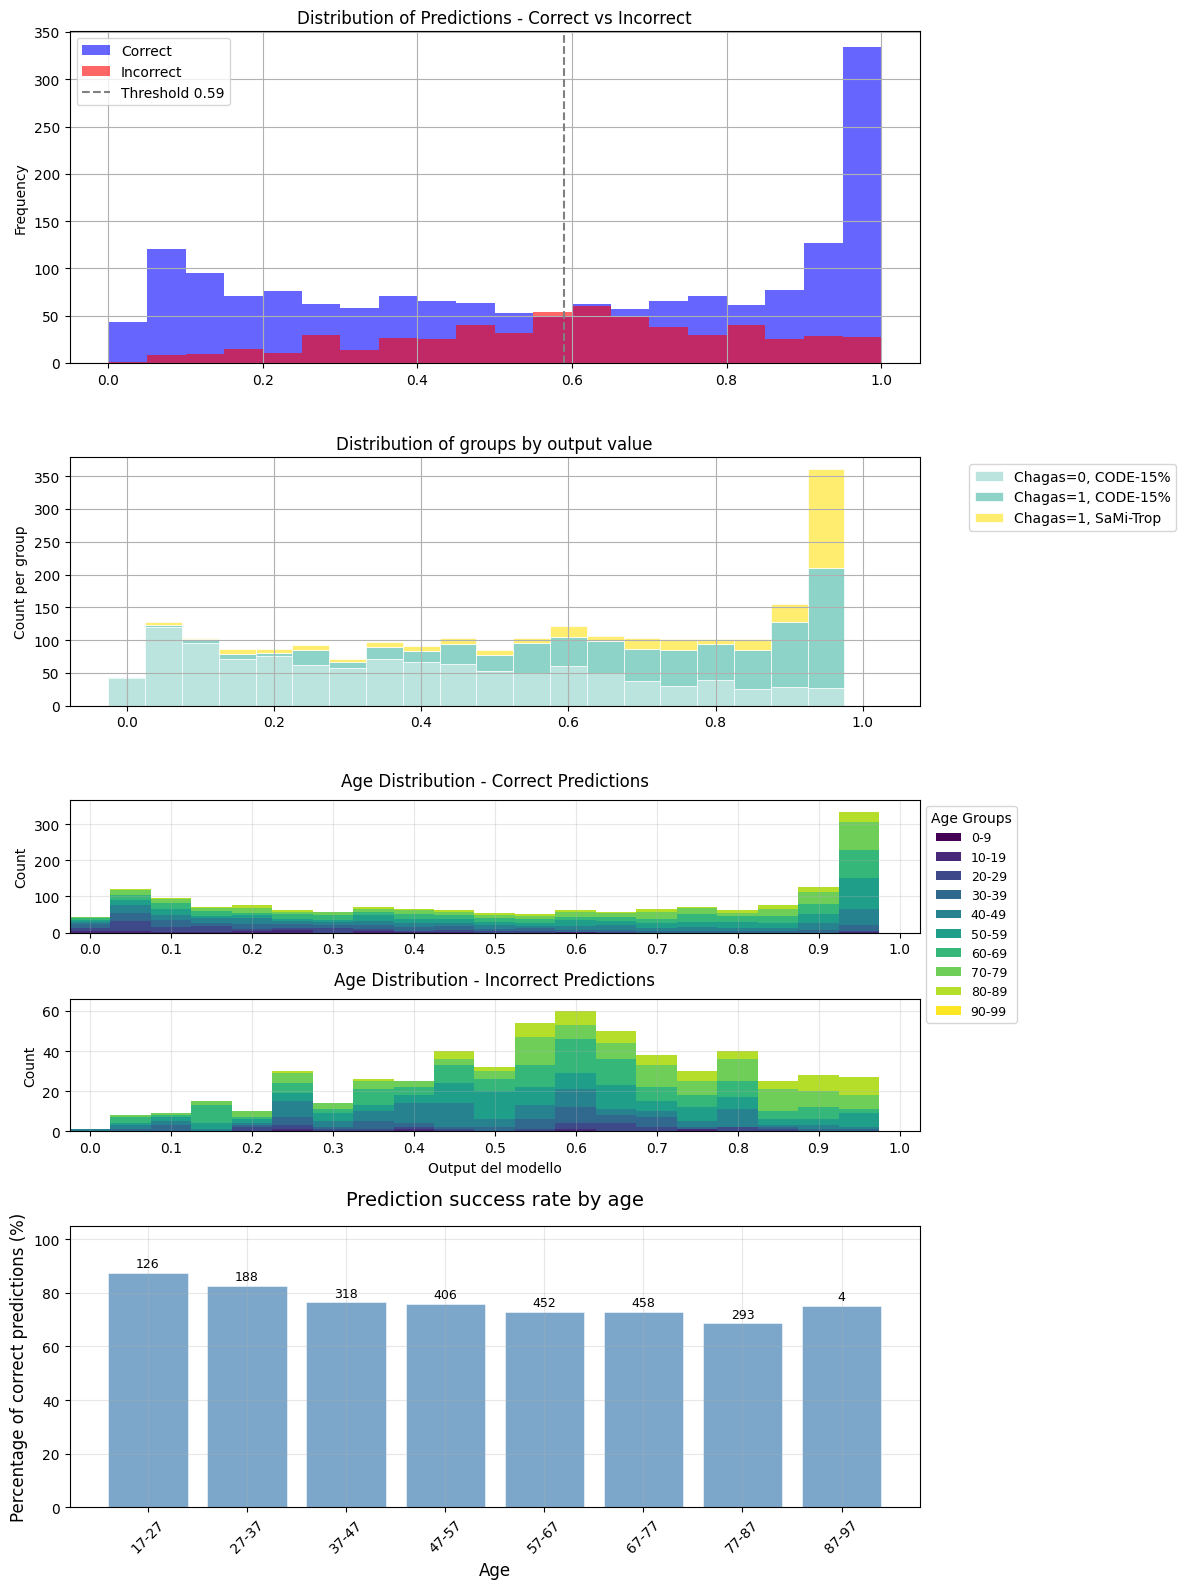

In [9]:
from models.analysis import plot_model_analysis

plot_model_analysis(model, X_test, y_test, y_test_info, threshold, return_pillow=False)